In [1]:
import os
import natsort
import cv2 as cv
import numpy as np
import tensorflow as tf
from keras import optimizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
    Dropout,
)
from keras.callbacks import EarlyStopping

In [33]:
# Define paths
data_dir_og = os.path.abspath(os.path.join(os.pardir, "original_images"))
data_dir_mask = os.path.abspath(os.path.join(os.pardir, "skin_masks"))


In [34]:
# Load images
res_images = np.zeros((len(os.listdir(data_dir_og)), 128, 128, 3))
res_masks = np.zeros((len(os.listdir(data_dir_mask)), 128, 128, 3))

new_size = (128, 128)

for i, (og, mask) in enumerate(
    zip(
        natsort.natsorted(os.listdir(data_dir_og)),
        natsort.natsorted(os.listdir(data_dir_mask)),
    ),
):
    img = cv.imread(data_dir_og + "/" + og)
    img = img / 255.0
    img = cv.resize(img, new_size)
    img = np.asarray(img).reshape((-1, 128, 128, 3))

    img_mask = cv.imread(data_dir_mask + "/" + mask)
    img_mask = img_mask / 255.0
    img_mask = cv.resize(img_mask, new_size)
    img_mask = np.asarray(img_mask).reshape((-1, 128, 128, 3))

    res_images[i] = img
    res_masks[i] = img_mask

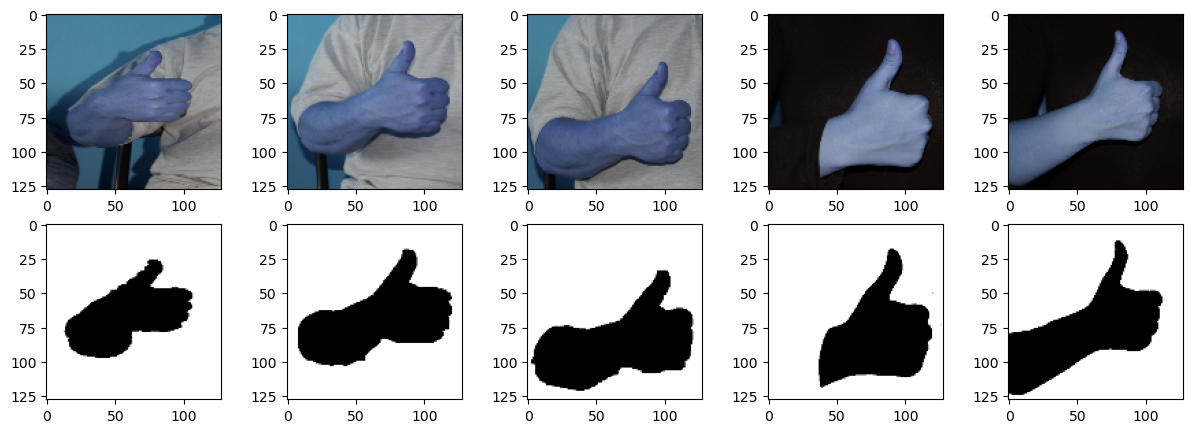

In [35]:
# plot first 5 images with corresponding masks
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    ax[0, i].imshow(res_images[i])
    ax[1, i].imshow(res_masks[i])


In [38]:
# split data into train and test
X_temp, X_test, y_temp, y_test = train_test_split(
    res_images, res_masks, test_size=0.2, random_state=42, shuffle=True
)


In [39]:
# perform data augmentation
X_rot = np.zeros((X_temp.shape[0] * 4, 128, 128, 3))
y_rot = np.zeros((y_temp.shape[0] * 4, 128, 128, 3))

for i in range(X_temp.shape[0]):
    X_rot[i * 4] = X_temp[i]
    y_rot[i * 4] = y_temp[i]

    X_rot[i * 4 + 1] = np.rot90(X_temp[i], 1)
    y_rot[i * 4 + 1] = np.rot90(y_temp[i], 1)

    X_rot[i * 4 + 2] = np.rot90(X_temp[i], 2)
    y_rot[i * 4 + 2] = np.rot90(y_temp[i], 2)

    X_rot[i * 4 + 3] = np.rot90(X_temp[i], 3)
    y_rot[i * 4 + 3] = np.rot90(y_temp[i], 3)

In [40]:
# train val split
X_train, X_val, y_train, y_val = train_test_split(
    X_rot, y_rot, test_size=0.2, random_state=42, shuffle=True
)


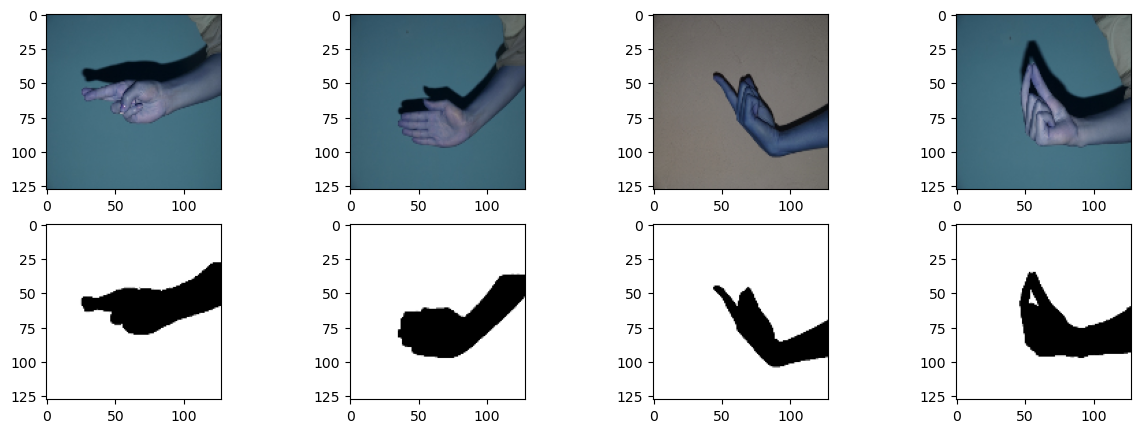

In [41]:
# plot 4 that were rotated
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    ax[0, i].imshow(X_train[i])
    ax[1, i].imshow(y_train[i])


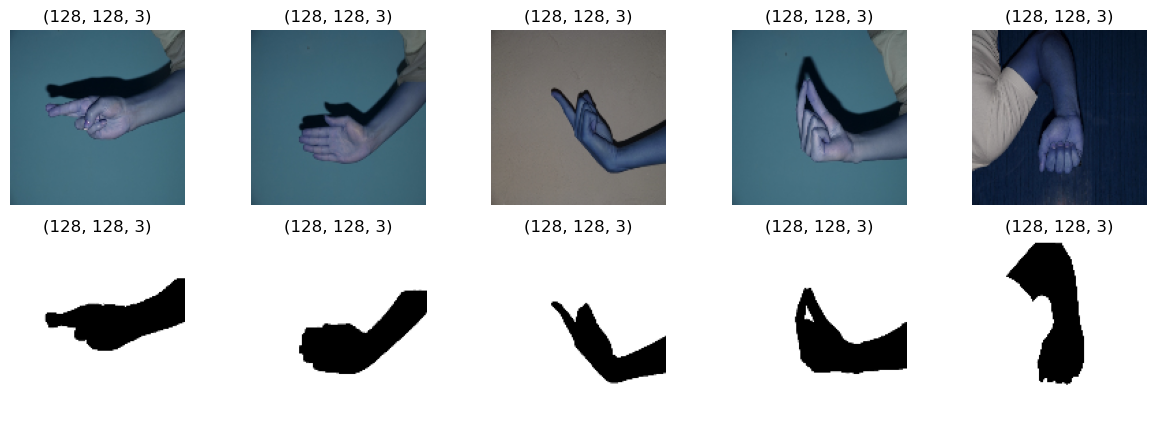

In [42]:
# check if shapes are correct
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
ax = ax.flatten()
for i in range(5):
    ax[i].imshow(X_train[i])
    ax[i].set_title(f"{X_train[i].shape}")
    ax[i].axis("off")
    ax[i + 5].imshow(y_train[i])
    ax[i + 5].set_title(f"{y_train[i].shape}")
    ax[i + 5].axis("off")


In [111]:
# define model
def unet(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(inputs)
    conv1 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool1)
    conv2 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool2)
    conv3 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool3)
    conv4 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv4)
    drop4 = Dropout(0.5)(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(
        1024, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool4)
    conv5 = Conv2D(
        1024, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(
        512, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge6)
    conv6 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv6)

    up7 = Conv2D(
        256, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge7)
    conv7 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv7)

    up8 = Conv2D(
        128, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge8)
    conv8 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv8)
    drop8 = Dropout(0.5)(conv8)

    up9 = Conv2D(
        64, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(UpSampling2D(size=(2, 2))(drop8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge9)
    conv9 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv9)

    conv10 = Conv2D(3, 1, activation="sigmoid")(conv9)

    unet = Model(inputs=inputs, outputs=conv10)

    early_stopping = EarlyStopping(
        patience=5,
        verbose=1,
        monitor="val_loss",
    )

    unet.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return unet

In [12]:
# compile model
unet = Model(input_img, unet(input_img))
unet.compile(loss="mean_squared_error", optimizer=optimizers.rmsprop_v2.RMSprop())

In [112]:
input_shape = (128, 128, 3)
model = unet(input_shape)


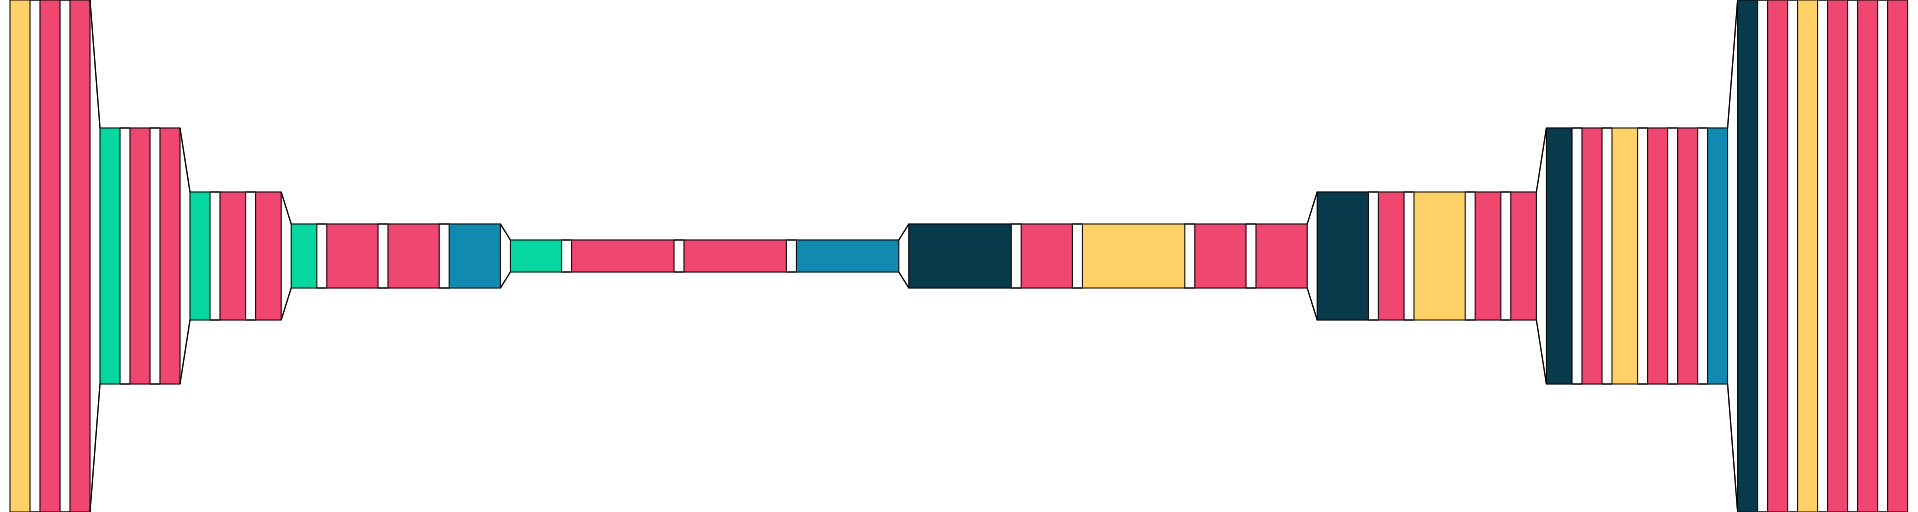

In [113]:
# create a visual representation of the model
visualkeras.layered_view(model, draw_volume=False)  # display using your system viewer

In [47]:
# fit model
unet_train = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test),
)

Epoch 1/10
72/72 [==============================] - 92s 1s/step - loss: 0.0577 - accuracy: 0.3330 - val_loss: 0.0442 - val_accuracy: 0.3753
Epoch 2/10
72/72 [==============================] - 90s 1s/step - loss: 0.0412 - accuracy: 0.3749 - val_loss: 0.0406 - val_accuracy: 0.4747
Epoch 3/10
72/72 [==============================] - 91s 1s/step - loss: 0.0364 - accuracy: 0.4013 - val_loss: 0.0415 - val_accuracy: 0.3976
Epoch 4/10
72/72 [==============================] - 92s 1s/step - loss: 0.0363 - accuracy: 0.3937 - val_loss: 0.0402 - val_accuracy: 0.3239
Epoch 5/10
72/72 [==============================] - 91s 1s/step - loss: 0.0335 - accuracy: 0.3570 - val_loss: 0.0384 - val_accuracy: 0.3657
Epoch 6/10
72/72 [==============================] - 91s 1s/step - loss: 0.0302 - accuracy: 0.3743 - val_loss: 0.0349 - val_accuracy: 0.4422
Epoch 7/10
72/72 [==============================] - 93s 1s/step - loss: 0.0291 - accuracy: 0.3623 - val_loss: 0.0338 - val_accuracy: 0.2510
Epoch 8/10
72/72 [==

2023-04-14 14:28:00.162287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 381ms/step


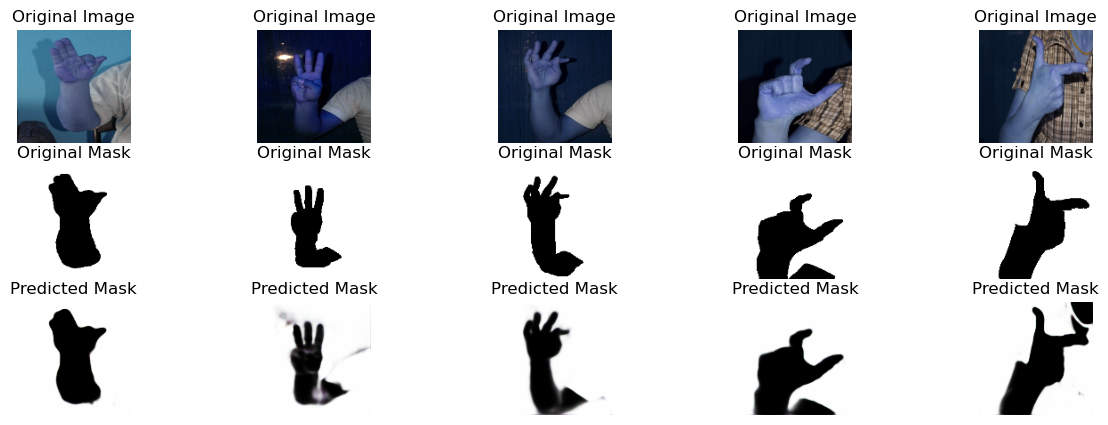

In [48]:
# evaluate the model
predicted_masks = model.predict(X_test)

# for the first 5 images plot the original, the mask and the predicted mask
fig, ax = plt.subplots(3, 5, figsize=(15, 5))
ax = ax.flatten()
for i in range(5):
    ax[i].imshow(X_test[i], cmap="gray")
    ax[i].set_title(f"Original Image")
    ax[i].axis("off")
    ax[i + 5].imshow(y_test[i], cmap="gray")
    ax[i + 5].set_title(f"Original Mask")
    ax[i + 5].axis("off")
    ax[i + 10].imshow(predicted_masks[i], cmap="gray")
    ax[i + 10].set_title(f"Predicted Mask")
    ax[i + 10].axis("off")

In [82]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
acc = score[1]
print(f"Test accuracy: {acc*100:.2f}%")

Test loss: 0.008755347691476345
Test accuracy: 0.6806634068489075


In [51]:
# save the model
model.save("segment.h5")

In [10]:
# load the model
from tensorflow import keras

segmentation_model = keras.models.load_model("segment.h5")

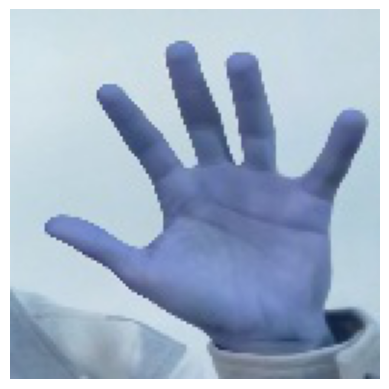

In [11]:
# load a test image
my_img = cv.imread("my_imgs/img.jpg")
my_img = cv.cvtColor(my_img, cv.COLOR_BGR2RGB)
my_image = np.expand_dims(my_img, axis=0)
plt.imshow(my_img)
plt.axis("off")
plt.show()

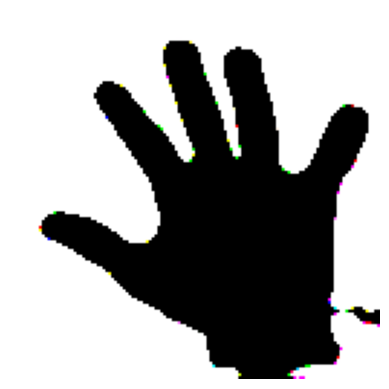

In [13]:
# predict the mask on the test image
prediction = segmentation_model.predict(my_image, verbose=0)
plt.imshow(prediction[0], cmap="Blues")
plt.axis("off")
plt.show()
